In [7]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tqdm
import matplotlib.pyplot as plt


In [2]:
# Check available CUDA devices and memory
if torch.cuda.is_available():
    num_devices = torch.cuda.device_count()
    for i in range(num_devices):
        device = torch.cuda.device(i)
        total_mem = torch.cuda.get_device_properties(i).total_memory / 1024**3  # Convert to GB
        allocated_mem = torch.cuda.memory_allocated(i) / 1024**3  # Convert to GB
        free_mem = total_mem - allocated_mem
        
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
        print(f"Total Memory: {total_mem:.1f}GB")
        print(f"Allocated Memory: {allocated_mem:.1f}GB")
        print(f"Free Memory: {free_mem:.1f}GB")
        
        if free_mem < 8:
            print(f"Warning: GPU {i} has less than 8GB of free VRAM!")
        else:
            print(f"Using GPU {i} with {free_mem:.1f}GB free VRAM")
            break 
    device = torch.device(f"cuda:{i}")
else:
    print("Warning: No CUDA devices available - running on CPU only")
    device = torch.device("cpu")


GPU 0: NVIDIA GeForce RTX 4070 Ti
Total Memory: 12.0GB
Allocated Memory: 0.0GB
Free Memory: 12.0GB
Using GPU 0 with 12.0GB free VRAM


In [ ]:
#normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [3]:
class SolarPV(Dataset):
    # Initialise dataset
    def __init__(self, df, seq_length):
        self.nl = df['NL'].values.astype('float32')
        self.gg = df['GG'].values.astype('float32')
        self.seq_length = seq_length

    # Return length of dataset
    def __len__(self):
        return len(self.nl) - self.seq_length

    # Load and return item from dataset
    def __getitem__(self, idx):
        x = self.nl[idx:idx + self.seq_length]
        y = self.gg[idx + self.seq_length]
        return torch.tensor(x, dtype=torch.float32).unsqueeze(-1), torch.tensor(y, dtype=torch.float32).unsqueeze(-1)

In [4]:
class LSTMModel(nn.Module):
    # Define LSTM model
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    # Forward pass through the model
    # x: input tensor of shape (batch_size, seq_length, input_size)
    # Returns output tensor of shape (batch_size, output_size)
    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

In [5]:
def train(model, dataloader, epochs, lr, device):
    # Define loss function and optimiser
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        model.train()
        total_loss = 0.0
        for x_batch, y_batch in dataloader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            optimizer.zero_grad()

            # Forward pass
            pred = model(x_batch)

            # Compute loss
            loss = criterion(pred, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        # Average loss for the epoch
        avg_loss = total_loss / len(dataloader)
        
        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {avg_loss:.4f}")

Evaluate model performance

In [6]:
def evaluate(model, dataloader, device):
    model.eval()
    preds = []
    targets = []

    with torch.no_grad():
        for x_batch, y_batch in dataloader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            pred = model(x_batch)

            #preds.extend(pred.cpu().numpy())
            #targets.extend(y_batch.cpu().numpy())
            #preds.extend(pred.squeeze().numpy())
            #targets.extend(y_batch.squeeze().numpy())
            preds.extend(pred.squeeze().cpu().numpy())
            targets.extend(y_batch.squeeze().cpu().numpy())
            

    mae = mean_absolute_error(targets, preds)
    mse = mean_squared_error(targets, preds)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((np.array(targets) - np.array(preds)) / np.array(targets))) * 100
    r2 = r2_score(targets, preds)
    print(f"R2 Score: {r2:.4f}")
    print(f"Evaluation - MAE: {mae:.4f}, MSE: {mse:.4f}, RMSE: {rmse:.4f}, MAPE: {mape:.2f}%")
    return preds, targets

In [7]:
# Use 2 years of data for training and 1 year for testing
df_train = pd.read_csv("processed_data/2010-2011/NL_2010-2011_1.csv")
df_test = pd.read_csv("processed_data/2012-2013/NL_2012-2013_1.csv")

In [8]:
df_train.head()

,Customer,date,Time,GC,datetime,GG,CL,NL
0,1,01-Jul-10,0:00,0.125,2010-07-01 00:00:00,0.0,1.075,1.200
1,1,01-Jul-10,0:30,0.303,2010-07-01 00:30:00,0.0,1.250,1.553
2,1,01-Jul-10,1:00,0.471,2010-07-01 01:00:00,0.0,1.244,1.715
3,1,01-Jul-10,1:30,0.083,2010-07-01 01:30:00,0.0,1.256,1.339
4,1,01-Jul-10,2:00,0.121,2010-07-01 02:00:00,0.0,0.744,0.865


In [9]:
df_test.head()

,Customer,date,Row Quality_x,Time,GC,datetime,Row Quality_y,GG,Row Quality,CL,NL
0,1,1/07/2012,NaN,0:00,0.068,2012-07-01 00:00:00,NaN,0.0,NaN,1.081,1.149
1,1,1/07/2012,NaN,0:30,0.855,2012-07-01 00:30:00,NaN,0.0,NaN,1.250,2.105
2,1,1/07/2012,NaN,1:00,0.786,2012-07-01 01:00:00,NaN,0.0,NaN,1.250,2.036
3,1,1/07/2012,NaN,1:30,0.604,2012-07-01 01:30:00,NaN,0.0,NaN,1.250,1.854
4,1,1/07/2012,NaN,2:00,0.544,2012-07-01 02:00:00,NaN,0.0,NaN,1.263,1.807


In [10]:
# Create DataLoader for training data
train_dataset = SolarPV(df_train, seq_length=24)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Create DataLoader for test data
test_dataset = SolarPV(df_test, seq_length=24)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Check dataset length
print(f"Total samples available: {len(train_dataset)}")

Total samples available: 17496


In [11]:
# Retrieve first sample
x, y = train_dataset[0]

print("NL sequence shape:", x.shape)
print("GG value:", y)

NL sequence shape: torch.Size([24, 1])
GG value: tensor([0.7380])


In [12]:
for x_batch, y_batch in train_dataloader:
    print("Batch NL shape:", x_batch.shape)
    print("Batch GG shape:", y_batch.shape)
    break  # Only print first batch

Batch NL shape: torch.Size([32, 24, 1])
Batch GG shape: torch.Size([32, 1])


In [13]:
# Test evaluate function
model = LSTMModel(input_size=1, hidden_size=64, num_layers=2, output_size=1).to(device)
preds, targets = evaluate(model, test_dataloader, device)

# Calculate evaluation metrics
mae = mean_absolute_error(targets, preds)
mse = mean_squared_error(targets, preds)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((np.array(targets) - np.array(preds)) / np.array(targets))) * 100
r2 = r2_score(targets, preds)

print(f"MAE  (Mean Absolute Error):      {mae:.4f}")
print(f"MSE  (Mean Squared Error):       {mse:.4f}")
print(f"RMSE (Root Mean Squared Error):  {rmse:.4f}")
print(f"MAPE (Mean Absolute % Error):    {mape:.2f}%")
print(f"R²   (Coefficient of Determination): {r2:.4f}")

R2 Score: -0.6353
Evaluation - MAE: 0.3729, MSE: 0.3511, RMSE: 0.5926, MAPE: inf%
MAE  (Mean Absolute Error):      0.3729
MSE  (Mean Squared Error):       0.3511
RMSE (Root Mean Squared Error):  0.5926
MAPE (Mean Absolute % Error):    inf%
R²   (Coefficient of Determination): -0.6353


/tmp/ipykernel_9147/984970986.py:22: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((np.array(targets) - np.array(preds)) / np.array(targets))) * 100
/tmp/ipykernel_9147/3692321219.py:9: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((np.array(targets) - np.array(preds)) / np.array(targets))) * 100


In [14]:
#Initialise model
model = LSTMModel(input_size=1, hidden_size=64, num_layers=2, output_size=1).to(device)
# Train the model
train(model, train_dataloader, epochs=10, lr=0.001, device=device)





Epoch [1/10], Loss: 0.0457
Epoch [2/10], Loss: 0.0290
Epoch [3/10], Loss: 0.0280
Epoch [4/10], Loss: 0.0272
Epoch [5/10], Loss: 0.0262
Epoch [6/10], Loss: 0.0250
Epoch [7/10], Loss: 0.0247
Epoch [8/10], Loss: 0.0241
Epoch [9/10], Loss: 0.0243
Epoch [10/10], Loss: 0.0236


Use GPU if available

In [ ]:
# Save the trained model
torch.save(model.state_dict(), 'solar_pv_model.pth')
# Load the trained model
model = LSTMModel(input_size=1, hidden_size=64, num_layers=2, output_size=1).to(device)
model.load_state_dict(torch.load('solar_pv_model.pth'))
# Set the model to evaluation mode
model.eval()
# Example usage of the trained model for prediction
with torch.no_grad():
    for x_batch, y_batch in test_dataloader:
        x_batch = x_batch.to(device)
        predictions = model(x_batch)
        print("Predictions shape:", predictions.shape)
        print("Actual values shape:", y_batch.shape)
        break  # Only print first batch predictions
# Evaluate the model on the test dataset
evaluate(model, test_dataloader, device=device)

In [17]:
preds, targets = evaluate(model, test_dataloader, device=device)

# Calculate evaluation metrics
mae = mean_absolute_error(targets, preds)
mse = mean_squared_error(targets, preds)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((np.array(targets) - np.array(preds)) / np.array(targets))) * 100
r2 = r2_score(targets, preds)

print(f"MAE  (Mean Absolute Error):      {mae:.4f}")
print(f"MSE  (Mean Squared Error):       {mse:.4f}")
print(f"RMSE (Root Mean Squared Error):  {rmse:.4f}")
print(f"MAPE (Mean Absolute % Error):    {mape:.2f}%")
print(f"R²   (Coefficient of Determination): {r2:.4f}")


R2 Score: 0.8967
Evaluation - MAE: 0.0834, MSE: 0.0222, RMSE: 0.1489, MAPE: inf%
MAE  (Mean Absolute Error):      0.0834
MSE  (Mean Squared Error):       0.0222
RMSE (Root Mean Squared Error):  0.1489
MAPE (Mean Absolute % Error):    inf%
R²   (Coefficient of Determination): 0.8967


/tmp/ipykernel_9147/984970986.py:22: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((np.array(targets) - np.array(preds)) / np.array(targets))) * 100
/tmp/ipykernel_9147/573146350.py:7: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((np.array(targets) - np.array(preds)) / np.array(targets))) * 100


In [9]:
# Use 2 years of data for training and 1 year for testing
df_train = pd.read_csv("community_data/community_1_train.csv")
df_test = pd.read_csv("community_data/community_1_test.csv")

In [10]:
df_train.head()

,Customer,date,Time,GC,datetime,GG,CL,NL,Row Quality_x,Row Quality_y,Row Quality
0,1,01-Jul-10,0:00,0.125,2010-07-01 00:00:00,0.0,1.075,1.200,NaN,NaN,NaN
1,1,01-Jul-10,0:30,0.303,2010-07-01 00:30:00,0.0,1.250,1.553,NaN,NaN,NaN
2,1,01-Jul-10,1:00,0.471,2010-07-01 01:00:00,0.0,1.244,1.715,NaN,NaN,NaN
3,1,01-Jul-10,1:30,0.083,2010-07-01 01:30:00,0.0,1.256,1.339,NaN,NaN,NaN
4,1,01-Jul-10,2:00,0.121,2010-07-01 02:00:00,0.0,0.744,0.865,NaN,NaN,NaN


In [11]:
df_test.head()

,Customer,date,Row Quality_x,Time,GC,datetime,Row Quality_y,GG,NL,Row Quality,CL
0,1,1/07/2012,NaN,0:00,0.068,2012-07-01 00:00:00,NaN,0.0,1.149,NaN,1.081
1,1,1/07/2012,NaN,0:30,0.855,2012-07-01 00:30:00,NaN,0.0,2.105,NaN,1.250
2,1,1/07/2012,NaN,1:00,0.786,2012-07-01 01:00:00,NaN,0.0,2.036,NaN,1.250
3,1,1/07/2012,NaN,1:30,0.604,2012-07-01 01:30:00,NaN,0.0,1.854,NaN,1.250
4,1,1/07/2012,NaN,2:00,0.544,2012-07-01 02:00:00,NaN,0.0,1.807,NaN,1.263


In [12]:
# Create DataLoader for training data
train_dataset = SolarPV(df_train, seq_length=24)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Create DataLoader for test data
test_dataset = SolarPV(df_test, seq_length=24)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Check dataset length
print(f"Total samples available: {len(train_dataset)}")

Total samples available: 2623416


In [13]:
# Retrieve first sample
x, y = train_dataset[0]

print("NL sequence shape:", x.shape)
print("GG value:", y)

NL sequence shape: torch.Size([24, 1])
GG value: tensor([0.7380])


In [14]:
for x_batch, y_batch in train_dataloader:
    print("Batch NL shape:", x_batch.shape)
    print("Batch GG shape:", y_batch.shape)
    break  # Only print first batch

Batch NL shape: torch.Size([32, 24, 1])
Batch GG shape: torch.Size([32, 1])


In [15]:
#Initialise model
model = LSTMModel(input_size=1, hidden_size=64, num_layers=2, output_size=1).to(device)
# Train the model
train(model, train_dataloader, epochs=10, lr=0.001, device=device)

Epoch [1/10], Loss: 0.0104
Epoch [2/10], Loss: 0.0092
Epoch [3/10], Loss: 0.0089
Epoch [4/10], Loss: 0.0086
Epoch [5/10], Loss: 0.0085
Epoch [6/10], Loss: 0.0083
Epoch [7/10], Loss: 0.0082
Epoch [8/10], Loss: 0.0081
Epoch [9/10], Loss: 0.0080
Epoch [10/10], Loss: 0.0079


In [16]:
preds, targets = evaluate(model, test_dataloader, device=device)

# Calculate evaluation metrics
mae = mean_absolute_error(targets, preds)
mse = mean_squared_error(targets, preds)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((np.array(targets) - np.array(preds)) / np.array(targets))) * 100
r2 = r2_score(targets, preds)

print(f"MAE  (Mean Absolute Error):      {mae:.4f}")
print(f"MSE  (Mean Squared Error):       {mse:.4f}")
print(f"RMSE (Root Mean Squared Error):  {rmse:.4f}")
print(f"MAPE (Mean Absolute % Error):    {mape:.2f}%")
print(f"R²   (Coefficient of Determination): {r2:.4f}")


/tmp/ipykernel_719/2845218755.py:23: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((np.array(targets) - np.array(preds)) / np.array(targets))) * 100
/tmp/ipykernel_719/2845218755.py:23: RuntimeWarning: invalid value encountered in divide
  mape = np.mean(np.abs((np.array(targets) - np.array(preds)) / np.array(targets))) * 100


R2 Score: 0.8749
Evaluation - MAE: 0.0487, MSE: 0.0091, RMSE: 0.0952, MAPE: nan%


/tmp/ipykernel_719/573146350.py:7: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((np.array(targets) - np.array(preds)) / np.array(targets))) * 100
/tmp/ipykernel_719/573146350.py:7: RuntimeWarning: invalid value encountered in divide
  mape = np.mean(np.abs((np.array(targets) - np.array(preds)) / np.array(targets))) * 100


MAE  (Mean Absolute Error):      0.0487
MSE  (Mean Squared Error):       0.0091
RMSE (Root Mean Squared Error):  0.0952
MAPE (Mean Absolute % Error):    nan%
R²   (Coefficient of Determination): 0.8749


In [22]:
# Print length of predictions and targets
print(f"Number of predictions: {len(preds)}")
print(f"Number of targets: {len(targets)}")

Number of predictions: 1306968
Number of targets: 1306968


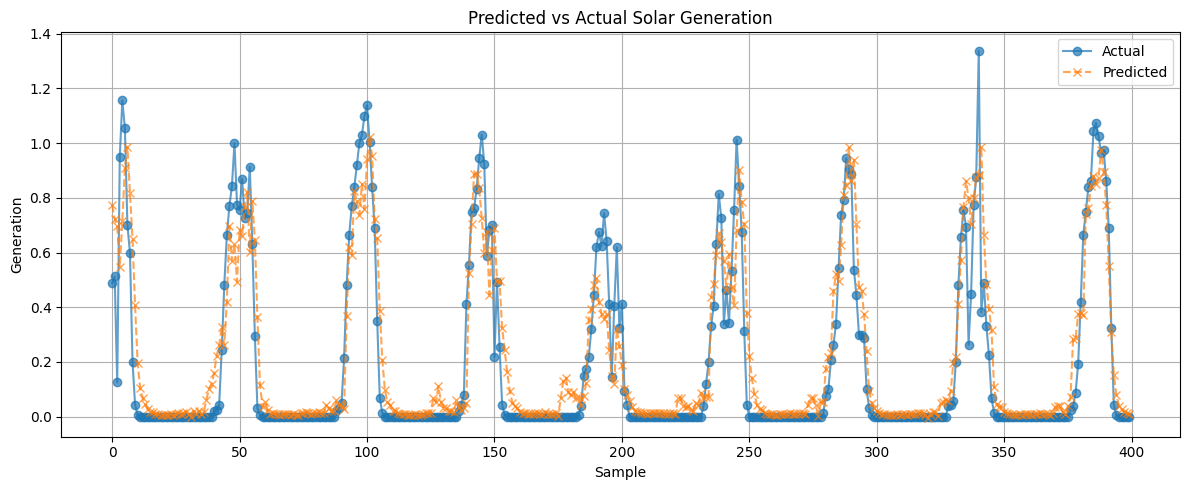

In [19]:
# Plot first 100 samples
plt.figure(figsize=(12, 5))
plt.plot(targets[:400], label='Actual', linestyle='-', marker='o', alpha=0.7)
plt.plot(preds[:400], label='Predicted', linestyle='--', marker='x', alpha=0.7)
plt.title("Predicted vs Actual Solar Generation")
plt.xlabel("Sample")
plt.ylabel("Generation")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


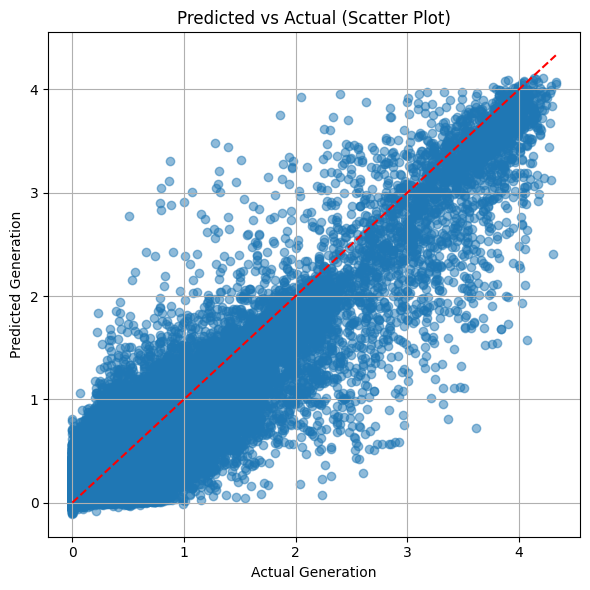

In [23]:
plt.figure(figsize=(6, 6))
plt.scatter(targets, preds, alpha=0.5)
plt.plot([min(targets), max(targets)], [min(targets), max(targets)], color='red', linestyle='--')
plt.title("Predicted vs Actual (Scatter Plot)")
plt.xlabel("Actual Generation")
plt.ylabel("Predicted Generation")
plt.grid(True)
plt.tight_layout()
plt.show()
